# Analysis

The purpose of this notebook is to analyze the networks of users and tweets scraped from Twitter on the topic of anti-vax. The resulting data, including all calculated metrics, will be used for graphing the network on Polinode. All attributes on the Polinode graph will be from the python calculations, except for communities. This is due to the python calculated communities were read as continuous values rather than distinct values on Polinode, making the color labeling of different communities on the graphs difficult. Therefore, the communities shown on the graph where calculated on Polinode.

# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import networkx as nx
import community as louvain
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import nltk
import warnings
#suppress warnings
warnings.filterwarnings("ignore")

C:\Users\Kooritsuki\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Datasets

In [2]:
# load all data needed for analysis
edges_user = pd.read_csv("output/Combined Tweets/2020-12-24 edges_user.csv", dtype = str)
edges_user_unweighted = pd.read_csv("output/Combined Tweets/2020-12-24 edges_user_unweighted.csv", dtype = str)
edges_tweet = pd.read_csv("output/Combined Tweets/2020-12-24 edges_tweet.csv", dtype = str)
nodes_user = pd.read_csv("output/Combined Tweets/2020-12-24 nodes_user.csv", dtype = str)
nodes_tweet = pd.read_csv("output/Combined Tweets/2020-12-24 nodes_tweet.csv", dtype = str)

In [3]:
#set proper data type
edges_user["weight"] = edges_user["weight"].astype(int)
nodes_user["followers_count"] = nodes_user["followers_count"].astype(int)
nodes_user["following_count"] = nodes_user["following_count"].astype(int)
nodes_user["tweet_count"] = nodes_user["tweet_count"].astype(int)
nodes_tweet["hashtag_novax"] = nodes_tweet["hashtag_novax"].astype(int)
nodes_tweet["hashtag_antivax"] = nodes_tweet["hashtag_antivax"].astype(int)
nodes_tweet["hashtag_cdcwhistleblower"] = nodes_tweet["hashtag_cdcwhistleblower"].astype(int)
nodes_tweet["hashtag_vaccineinjury"] = nodes_tweet["hashtag_vaccineinjury"].astype(int)
nodes_tweet["hashtag_vaxxed"] = nodes_tweet["hashtag_vaxxed"].astype(int)
nodes_tweet["hashtag_cdcfraud"] = nodes_tweet["hashtag_cdcfraud"].astype(int)

# Tweets by Users Network

This section analyzes the network of users who tweeted, replied, quoted and/or retweeted posts that we scraped from Twitter.

## Create Directed Graph

In [4]:
#create directed graph and set egdes
g = nx.DiGraph()
g = nx.from_pandas_edgelist(edges_user, "Source", "Target", edge_attr = "weight", create_using = nx.DiGraph)

#set nodes and nodes attributes
for i in nodes_user.columns[1:] :
    nx.set_node_attributes(g, nodes_user[["Name", i]].set_index("Name")[i].to_dict(), i)

## Metrics Analysis

### Nodes and Edges

In [5]:
print("There are", g.number_of_nodes(), "nodes in this graph.")
print("There are", g.number_of_edges(), "edges in this graph.")

There are 6684 nodes in this graph.
There are 6834 edges in this graph.


### Diameter

The graph has many unconnected components, so we could not calculate the diameter directly. Instead, we must determine the largest connected components first, then calculate the diameter on it. However, the largest connected component of the graph is only weakly connected. Therefore, we decided to change the graph temporarly to undirected in order to calculate these metrics.

In [6]:
# save undirected version of the graph
g_undirected = g.to_undirected()

# determine the largest connected component of the undirected version of the graph
largest_connected = sorted(nx.connected_components(g_undirected), key = len, reverse = True)
largest_connected = g_undirected.subgraph(largest_connected[0])

In [7]:
# calculate the diameter of the largest component of the undirected version of the graph
print("The average short path length (undirected) is:", nx.diameter(largest_connected))

The average short path length (undirected) is: 24


### Average Path Length

As with diameter, the average path length cannot be calculated on an unconnected, weakly connected graph. Therefore, we have decided to use the directed version of the largest connected component to calculate this metric instead.

Note that even if the network is directed the average shortest path length is close to 7, meaning the connections are not great and information doesn't spread very widely in this network.

In [8]:
print("The average shortest path length (undirected) is:", nx.average_shortest_path_length(largest_connected))

The average shortest path length (undirected) is: 6.856197232833091


### Reciprocity

Reciprocity is a measure of the likelyihood of edges in a directed network to be mutually linked. As we can see from this reciprocity calculation, the reciprocity in this network is quite low. This means the probabilty of two-way conversations in this network is low with most of the users replying to a tweet but never getting a reply back.

In [9]:
print("The reciprocity is:", nx.reciprocity(g))

The reciprocity is: 0.07374890254609306


### Degrees & Centrality

#### Calculations

In [10]:
#calculate degrees
degree = pd.DataFrame.from_dict(dict(g.degree()), orient = "index", columns = ["degree"])
indegree = pd.DataFrame.from_dict(dict(g.in_degree()), orient = "index", columns = ["indegree"])
outdegree = pd.DataFrame.from_dict(dict(g.out_degree()), orient = "index", columns = ["outdegree"])

In [11]:
#calculate centralities
degree_centrality = pd.DataFrame.from_dict(nx.degree_centrality(g), orient = "index", columns = ["degree_centrality"])
eigenvector_centrality = pd.DataFrame.from_dict(nx.eigenvector_centrality(g), orient = "index", columns = ["eigenvector_centrality"])
closeness_centrality = pd.DataFrame.from_dict(nx.closeness_centrality(g), orient = "index", columns = ["closeness_centrality"])
betweenness_centrality = pd.DataFrame.from_dict(nx.betweenness_centrality(g), orient = "index", columns = ["betweenness_centrality"])

In [12]:
# calculate community with louvain algorithm
community_louvain = pd.DataFrame.from_dict(louvain.best_partition(g_undirected), orient = "index", columns = ["community_louvain"])

# calculate community with bipartition algorithm
community_bipartition = list(nx.algorithms.community.kernighan_lin.kernighan_lin_bisection(g_undirected))
community_bipartition = pd.DataFrame(community_bipartition).stack().reset_index()
community_bipartition = community_bipartition.drop(["level_1"], axis = 1).set_index(0)
community_bipartition = community_bipartition.rename(columns = {"level_0" : "community_bipartition"})
community_bipartition.index = community_bipartition.index.rename("")

# calculate community with modularity algorithm
community_modularity = list(nx.algorithms.community.modularity_max.greedy_modularity_communities(g_undirected))
community_modularity = pd.DataFrame(community_modularity).stack().reset_index()
community_modularity = community_modularity.drop(["level_1"], axis = 1).set_index(0)
community_modularity = community_modularity.rename(columns = {"level_0" : "community_modularity"})
community_modularity.index = community_modularity.index.rename("")

# calculate community with label propagation algorithm
community_label_propagation = list(nx.algorithms.community.label_propagation.label_propagation_communities(g_undirected))
community_label_propagation = pd.DataFrame(community_label_propagation).stack().reset_index()
community_label_propagation = community_label_propagation.drop(["level_1"], axis = 1).set_index(0)
community_label_propagation = community_label_propagation.rename(columns = {"level_0" : "community_label_propagation"})
community_label_propagation.index = community_label_propagation.index.rename("")

In [13]:
#concat into a single dataframe
calculations = pd.concat([degree, indegree, outdegree, degree_centrality, eigenvector_centrality,
                          closeness_centrality, betweenness_centrality, community_louvain,
                          community_bipartition, community_modularity, community_label_propagation],
                         ignore_index = False, axis = 1)

#join with nodes dataframe
nodes_user = nodes_user.join(calculations, on = "Name")

#### Total Degrees

We can see from the degree analysis of the users, that the majority of the users have only 1 total degree. Those who have high total degrees are the accounts of politicians and/or journalists with only one Doctor, with Donald Trump's account topping the chart.

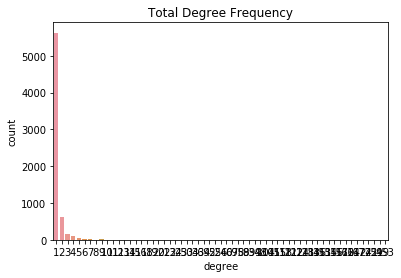

In [14]:
%matplotlib inline

#create histogram for total degrees
sns.countplot(x = "degree", data = nodes_user)
plt.title("Total Degree Frequency")
plt.show()

In [15]:
#top 10 users with the highest total degrees
top_degree_users = nodes_user.sort_values("degree", ascending = False).head(10)
top_degree_users[["Name", "degree"]].style.set_caption("Users with Top Total Degrees")

,Name,degree
1700,realDonaldTrump,453
4533,GeoRebekah,299
4535,ChrisWickNews,251
3035,DrMadej,241
5504,gtconway3d,177
4534,JosephJFlynn1,167
1579,TeamTrump,164
4450,marklevinshow,164
3012,simondolan,162
6557,AndrewYang,157


#### In-Degrees

As expected, the same accounts that topped the total degrees chart also topped the in-degrees chart. Many anti-vaxx and pro-vaxx tweets have @'d these accounts. However, from our dataset, none of the these accounts tweeted with our targeted hashtags, nor did they reply the tweets that @'d them. Therefore, their outdegree were almost all 0.

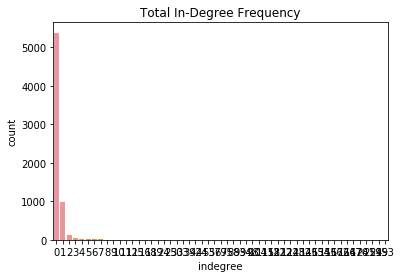

In [16]:
#create histogram for indegrees
sns.countplot(x = "indegree", data = nodes_user)
plt.title("Total In-Degree Frequency")
plt.show()

In [17]:
#top 10 users with the highest indegrees
top_indegree_users = nodes_user.sort_values("indegree", ascending = False).head(10)
top_indegree_users[["Name", "indegree", "outdegree"]].style.set_caption("Users with Top In-Degrees")

,Name,indegree,outdegree
1700,realDonaldTrump,453,0
4533,GeoRebekah,299,0
4535,ChrisWickNews,251,0
3035,DrMadej,241,0
5504,gtconway3d,176,1
4534,JosephJFlynn1,167,0
4450,marklevinshow,164,0
1579,TeamTrump,164,0
3012,simondolan,162,0
6557,AndrewYang,157,0


#### Out-Degree

Not many accounts have high out-degrees. Before the suspension of the anti-vaxx bot account "LotusOak2", it was the account with the highest outdegree. However, since this final dataset was gathered after the suspension of the account, it was not included in this dataset.

Instead, we see the user CCPvirus_ topping the outdegree chart. While its outdegree for the anti-vaxx topic is not as high as would be expected of an anti-vaxx bot, it tweeted frequently on pro-Trump and anti-China topics.

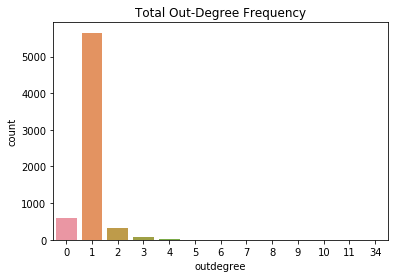

In [18]:
#create histogram for outdegrees
sns.countplot(x = "outdegree", data = nodes_user)
plt.title("Total Out-Degree Frequency")
plt.show()

In [19]:
#top 10 users with the highest outdegrees
top_outdegree_users = nodes_user.sort_values("outdegree", ascending = False).head(10)
top_outdegree_users[["Name", "outdegree", "indegree"]].style.set_caption("Users with Top In-Degrees")

,Name,outdegree,indegree
2490,CCPvirus_,34,0
3528,maxthelionx,11,25
3577,MALlCE_,10,3
5442,GATXER,10,1
5326,DrDanilychevMD,10,10
5319,TCvnts,9,0
2241,jonathanstea,8,44
2168,deanos5150,8,1
4954,steber232,8,5
2140,Rosewind2007,7,16


### Centralities

#### Degree Centrality

As expected, the individuals with top degree centrality are also the ones who have a high total degree. This means they are connected to many people and have many people engage with them on twitter. However, the majority of the users who engage with them on the topic of anti-vaxx are not of very high importance, as these top 10 users' eigenvector centrality is low. They do, however, have high closeness centrality, meaning that they are at the center of everyone who they are connected to. Therefore, they can be very influential when they do tweet about an opinion or a fact. Accounts like these should be monitor more closely in case any misinformation are posted.

In [20]:
#set to display full columns
pd.set_option('display.max_colwidth', -1)

#top 10 users with the highest degree centrality
top_degree_centrality_users = nodes_user.sort_values("degree_centrality", ascending = False)
top_degree_centrality_users[["Name", "betweenness_centrality", "degree_centrality", "eigenvector_centrality",
                             "closeness_centrality"]].head(10).style.set_caption("Users with Top Degree Centrality")

,Name,betweenness_centrality,degree_centrality,eigenvector_centrality,closeness_centrality
1700,realDonaldTrump,0.000000,0.067784,0.000000,0.067804
4533,GeoRebekah,0.000000,0.044740,0.000000,0.044647
4535,ChrisWickNews,0.000000,0.037558,0.000000,0.035222
3035,DrMadej,0.000000,0.036062,0.001748,0.034795
5504,gtconway3d,0.000000,0.026485,0.000000,0.026187
4534,JosephJFlynn1,0.000000,0.024989,0.000000,0.023034
1579,TeamTrump,0.000000,0.024540,0.000000,0.024412
4450,marklevinshow,0.000000,0.024540,0.000000,0.024543
3012,simondolan,0.000000,0.024241,0.000000,0.024226
6557,AndrewYang,0.000000,0.023492,0.000000,0.023515


### Eigenvector Centrality

While they don't necessarily have a lot of connections within this network themselves, they are connected to other user of importance within the network. This means that the users who engaged with their posts are well connected themselves. Pushing informative, factual posts regarding vaccines to these users can be beneficial as the replies, quotes or retweets of their posts have a higher possibility of receiving much more exposure to their second degree network.

A few of these users are also from the healthcare community, which means their engagement with posts containing accurate information will likely increase credibility of the post.

Upon investigation, we discovered that several of the users with top eigenvector centrality are also quite middle-of-the-road when it comes to the anti-vax movement. Therefore, providing them with more posts containing accurate information can be highly effective, as they are more likely consider them rather than outright rejecting them.

Per the SNA graph, however, we can see that all of the users with top 10 eigenvector centrality have engaged with Rosewind2007 either directly or has a second degree connection with her. In addition, although she's pro-vaxxer, her tweets were also able to reach highly active pro-vaxxer WAPFLondon. While he was not highly connected within our dataset, which was obtained in a span of one week, he does have a high followers count, which meant his replies to Rosewind2007 could be very visible.

In [21]:
#top 10 users with the highest degree centrality
top_eigenvector_centrality_users = nodes_user.sort_values("eigenvector_centrality", ascending = False)
top_eigenvector_centrality_users[["Name", "eigenvector_centrality", "degree_centrality", "betweenness_centrality",
                                  "closeness_centrality"]].head(10).style.set_caption("Users with Top EigenVector Centrality")

,Name,eigenvector_centrality,degree_centrality,betweenness_centrality,closeness_centrality
2140,Rosewind2007,0.594850,0.003442,0.000012,0.005204
2241,jonathanstea,0.569658,0.007781,0.000016,0.006708
4563,WAPFLondon,0.247404,0.001197,0.000002,0.003416
4568,HelenEBedford,0.174732,0.000748,0.000002,0.003395
4570,MelMcCurtis,0.161804,0.000449,0.000000,0.003374
4569,andyco98,0.161804,0.000449,0.000000,0.003374
4560,nickser1972,0.161804,0.000299,0.000000,0.003334
2245,lbertaAdvantage,0.154955,0.000299,0.000000,0.003894
2240,TrumpKennels,0.154955,0.000299,0.000000,0.003894
2242,AmyTanBeach,0.154955,0.000299,0.000000,0.003894


### Closeness Centrality

Users with top closeness centrality are also the same users with top degree centrality. Please see degree centralization for analysis.

In [22]:
#top 10 users with the highest degree centrality
top_closeness_centrality_users = nodes_user.sort_values("closeness_centrality", ascending = False)
top_closeness_centrality_users[["Name", "betweenness_centrality", "degree_centrality", "eigenvector_centrality",
                                "closeness_centrality"]].head(10).style.set_caption("Users with Top Closeness Centrality")

,Name,betweenness_centrality,degree_centrality,eigenvector_centrality,closeness_centrality
1700,realDonaldTrump,0.000000,0.067784,0.000000,0.067804
4533,GeoRebekah,0.000000,0.044740,0.000000,0.044647
4535,ChrisWickNews,0.000000,0.037558,0.000000,0.035222
3035,DrMadej,0.000000,0.036062,0.001748,0.034795
5504,gtconway3d,0.000000,0.026485,0.000000,0.026187
4450,marklevinshow,0.000000,0.024540,0.000000,0.024543
1579,TeamTrump,0.000000,0.024540,0.000000,0.024412
3012,simondolan,0.000000,0.024241,0.000000,0.024226
6557,AndrewYang,0.000000,0.023492,0.000000,0.023515
4534,JosephJFlynn1,0.000000,0.024989,0.000000,0.023034


### Betweenness Centrality

Users with high betweenness are important as information often passes through one community or cluster of the user to another. Unsurprisingly, a few of these top users are scientists and medical professionals. The top 7 users in betweenness centrality are all pro-vax voices amongst tweets with anti-vax related hashtags. Their posts are generally related to scientific facts rather than anecdotal evidence, and many will debunk misinformation being spread amongst the anti-vax community. 

The other 3 users, on the other hand, posts mostly anti-vax related tweets.

Different from the other 2, however, DrDanilychevMD, who is a healthcare professional according to his profile,
shares more posts related to researches and encourages others to seek more scientific information that is not influenced by any politics or anecdotal evidence. We believe that he is more likely to be receiptive of scientifically backed vaccine related posts than the other two users.

Therefore, more accurate and informational tweets should be directed to these users with high betweenness centrality in hopes of their retweets and engagements to reach different clusters of users on Twitter.

This is especially true for Rosewind2007, jonathanstea, and DrDanilychevMD, as they also have a high eigenvector centrality, meaning that they have a connection with users who are considered more important in the topic.

In [23]:
#top 10 users with the highest degree centrality
top_betweenness_centrality_users = nodes_user.sort_values("betweenness_centrality", ascending = False)
top_betweenness_centrality_users[["Name", "betweenness_centrality", "degree_centrality", "eigenvector_centrality",
                                  "closeness_centrality"]].head(10).style.set_caption("Users with Top Betweenness Centrality")

,Name,betweenness_centrality,degree_centrality,eigenvector_centrality,closeness_centrality
4957,BallouxFrancois,0.000016,0.008978,0.000045,0.008189
2241,jonathanstea,0.000016,0.007781,0.569658,0.006708
2140,Rosewind2007,0.000012,0.003442,0.594850,0.005204
4954,steber232,0.000009,0.001945,0.000119,0.004846
3528,maxthelionx,0.000007,0.005387,0.000294,0.003741
589,k_klo224743370,0.000006,0.008080,0.000000,0.007841
587,JSDH_S,0.000005,0.001347,0.000000,0.004460
2,and_kell,0.000004,0.005088,0.000000,0.004324
5326,DrDanilychevMD,0.000004,0.002993,0.015184,0.001539
4955,MartyKoekemoer,0.000003,0.000599,0.000019,0.005027


In [24]:
# nodes_tweet[nodes_tweet["author_username"] == "and_kell"][["Name", "author_username", "text"]]

### Communities

There are no community detection algorithm for directed graph, so we decided to use undirected versions of the graph for the calculations instead. We tried several different methods of communities calculations, but other than the bipartion method, which splits the network into 2 communities, all gave us a large number of communities. After investigating the tweets and user interactions, we have determined that the Louvain method gave good separations in terms of topics that users discussed within the network.

## Influential Users - K-Core

In [25]:
# get rid of self looping in order to calculate k-core
g_no_selfloops = g.copy()
g_no_selfloops.remove_edges_from(nx.selfloop_edges(g_no_selfloops))

In [26]:
kcore = nx.core_number(g_no_selfloops)
kcore = pd.DataFrame.from_dict(kcore, orient = "index", columns = ["k_core"])

In [27]:
kcore.sort_values("k_core", ascending = False).head(10)

,k_core
DrDanilychevMD,4
PintoBlades,4
Starrla1979,4
2k20Bryant,3
CCPvirus_,3
lyne_ian,3
FlynnReggie1,3
Quicktake,3
kevinallin,3
k_klo224743370,3


## Diffusion Model

Since our objective is to push factual information to the community, we believe it would be interesting to simulate what would happen if we push the information to a different set of users. We will use the Voter Opinion Dynamics Diffusion model for this simulation. The model uses a simple rule that at each iteration, a random node will be selected and copies the opinion of one random neighbour.

The first simulation beings with a random 10% of "infected" nodes, representing the nodes we will focus on pushing factual information tweets to. As we can see, even after 20,000 iterations, the opinions of both sides remained pretty much the same.

The subsequent simulations uses the same parameters, but will start with different sets of "infected" nodes. These nodes are still approximately 8 - 10% of the entire network, but have the top centrality or k-core scores. As we can see, after 20,000 iterations, all of them narrowed the gap between the number of people holding the two opinions.

Out of all these simulations, we can see that pushing information to the users with the top 10% eigenvector centrality has the highest probability for success in terms of spreading factual information through this network.

Of course, we understand that this is a simulation and by showing certain users factual information does not necessarily mean they will change their opinions, but it is a good illustration on how having a different starting point, depending on the centralities of the users, can achieve different results.

In [28]:
# !pip install ndlib

In [29]:
import ndlib.models.ModelConfig as mc
import ndlib.models.opinions as op
import dynetx as dn
from past.builtins import xrange
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.palettes import Spectral11
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.bokeh.MultiPlot import MultiPlot

In [30]:
# Dynamic Network topology
dg = dn.DynGraph()

for t in xrange(0, 3):
#     g = nx.erdos_renyi_graph(200, 0.05)
    dg.add_interactions_from(g.edges(), t)

In [31]:
# Model selection starting with infected nodes selected at random
model = op.VoterModel(dg)
config = mc.Configuration()
config.add_model_parameter('fraction_infected', 0.1)

model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(10000)
trends = model.build_trends(iterations)

# Set visualization of model
viz_random = DiffusionTrend(model, trends)
viz_random.title = "Random 10% Start"
viz_random.ylabel = "% of Nodes"

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 772.70it/s]


In [32]:
# Model selection starting with infected nodes selected at random
model = op.VoterModel(dg)
config = mc.Configuration()
config.add_model_initial_configuration('Infected', top_eigenvector_centrality_users["Name"].head(600).tolist())

model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(10000)
trends = model.build_trends(iterations)

# Set visualization of model
viz_eigenvector = DiffusionTrend(model, trends)
viz_eigenvector.title = "600 Top Eigenvector Centrality Users"
viz_eigenvector.ylabel = "% of Nodes"

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 725.31it/s]


In [33]:
# Model selection starting with infected nodes selected at random
model = op.VoterModel(dg)
config = mc.Configuration()
config.add_model_initial_configuration('Infected', top_betweenness_centrality_users["Name"].head(600).tolist())

model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(10000)
trends = model.build_trends(iterations)

# Set visualization of model
viz_betweenness = DiffusionTrend(model, trends)
viz_betweenness.title = "600 Top Betweenness Centrality Users"
viz_betweenness.ylabel = "% of Nodes"

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 780.42it/s]


In [34]:
# Model selection starting with infected nodes selected at random
model = op.VoterModel(dg)
config = mc.Configuration()
config.add_model_initial_configuration('Infected', top_degree_centrality_users["Name"].head(600).tolist())

model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(10000)
trends = model.build_trends(iterations)

# Set visualization of model
viz_degree = DiffusionTrend(model, trends)
viz_degree.title = "600 Top Degree Centrality Users"
viz_degree.ylabel = "% of Nodes"

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 692.03it/s]


In [35]:
# Model selection starting with infected nodes selected at random
model = op.VoterModel(dg)
config = mc.Configuration()
config.add_model_initial_configuration('Infected', kcore.head(600).index.tolist())

model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(10000)
trends = model.build_trends(iterations)

# Set visualization of model
viz_kcore = DiffusionTrend(model, trends)
viz_kcore.title = "600 Top K-Core Users"
viz_kcore.ylabel = "% of Nodes"

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 812.27it/s]


In [36]:
output_notebook()

mp = MultiPlot()
mp.add_plot(viz_random.plot(width = 400, height = 400))
mp.add_plot(viz_eigenvector.plot(width = 400, height = 400))
mp.add_plot(viz_betweenness.plot(width = 400, height = 400))
mp.add_plot(viz_degree.plot(width = 400, height = 400))
mp.add_plot(viz_kcore.plot(width = 400, height = 400))

#visualize the Diffusion Trend
p = mp.plot()
show(p)

Loading BokehJS ...

In [37]:
# #visualize the Diffusion Prevalence
# viz = DiffusionPrevalence(model, trends)
# p = viz.plot(width=800, height=400)
# show(p)

## Add Adjustments to Selected Metrics Prior to Exporting to Polinode

Some of the degree centrality calculated are also very low. This made using them as size/color attribute on the graph difficult. Therefore, we have created new columns to increase the centrality while keeping the scale. These columns are used only for the purposes of setting the size/color attribute on the graph.

In [38]:
#make values of degree centrality porportionally bigger for graphing purposes
nodes_user["degree_centrality_adjusted"] = nodes_user["degree_centrality"]*1000

#make values of eigenvector centrality porportionally bigger for graphing purposes
nodes_user["eigenvector_centrality_adjusted"] = nodes_user["eigenvector_centrality"]*100

#make values of closeness centrality porportionally bigger for graphing purposes
nodes_user["closeness_centrality_adjusted"] = nodes_user["closeness_centrality"]*1000

#make values of betweenness centrality porportionally bigger for graphing purposes
nodes_user["betweenness_centrality_adjusted"] = nodes_user["betweenness_centrality"]*1e6

## Export File to Graph in Polinode

In [39]:
with pd.ExcelWriter("output/Combined Tweets/To Graph/tweets_by_user.xlsx") as writer :
    nodes_user.to_excel(writer, sheet_name = "Nodes", index = False)
    edges_user.to_excel(writer, sheet_name = "Edges", index = False)

# Tweets Network

Unlike with tweets by user, we will not be doing an in-depth analysis on this network. This is because this network looks at the tweets themselves and how the posts, replies, quotes, retweets are connected. Therefore, most connections are, unsurprisingly, restricted to within their own conversations.

In addition, due to some of the tweets and users being deleted during or subsequently during our scraping, the information for this network is not as complete as it should be. However, we will still create this graph for illustration purposes and the metrics will be calculated to be used as attributes on the graph.

## Create Directed Graph

In [40]:
g_t = nx.DiGraph()
g_t = nx.from_pandas_edgelist(edges_tweet, "Source", "Target", create_using = nx.DiGraph)

#set nodes and nodes attributes
for i in nodes_tweet.columns[1:] :
    nx.set_node_attributes(g_t, nodes_tweet[["Name", i]].set_index("Name")[i].to_dict(), i)

## Calculate Metrics

### Nodes and Edges

In [41]:
print("There are", g_t.number_of_nodes(), "nodes in this graph.")
print("There are", g_t.number_of_edges(), "edges in this graph.")

There are 3591 nodes in this graph.
There are 3125 edges in this graph.


### Degrees

In [42]:
#calculate degrees
degree = pd.DataFrame.from_dict(dict(g_t.degree()), orient = "index", columns = ["degree"])
indegree = pd.DataFrame.from_dict(dict(g_t.in_degree()), orient = "index", columns = ["indegree"])
outdegree = pd.DataFrame.from_dict(dict(g_t.out_degree()), orient = "index", columns = ["outdegree"])

### Centralities

In [43]:
#calculate centralities
degree_centrality = pd.DataFrame.from_dict(nx.degree_centrality(g_t), orient = "index", columns = ["degree_centrality"])
closeness_centrality = pd.DataFrame.from_dict(nx.closeness_centrality(g_t), orient = "index", columns = ["closeness_centrality"])
betweenness_centrality = pd.DataFrame.from_dict(nx.betweenness_centrality(g_t), orient = "index", columns = ["betweenness_centrality"])

# #unable to calculate eigenvector
# eigenvector_centrality = pd.DataFrame.from_dict(nx.eigenvector_centrality(g_t), orient = "index", columns = ["eigenvector_centrality"])

### Community Detection

As with the tweets by users network, community dection algorithms were unavailable for undirected graphs. Therefore, the graph was temporarily made into a direct graph in order to calculate the communities.

In [44]:
# create undirected graph from directed graph
g_t_undirected = g_t.to_undirected()

# calculate communities using louvain algorithm
community_louvain = pd.DataFrame.from_dict(louvain.best_partition(g_t_undirected), orient = "index", columns = ["community_louvain"])

# calculate communities using bipartition algorithm
community_bipartition = list(nx.algorithms.community.kernighan_lin.kernighan_lin_bisection(g_t_undirected))
community_bipartition = pd.DataFrame(community_bipartition).stack().reset_index()
community_bipartition = community_bipartition.drop(["level_1"], axis = 1).set_index(0)
community_bipartition = community_bipartition.rename(columns = {"level_0" : "community_bipartition"})
community_bipartition.index = community_bipartition.index.rename("")

# calculate communities using modularity algorithm
community_modularity = list(nx.algorithms.community.modularity_max.greedy_modularity_communities(g_t_undirected))
community_modularity = pd.DataFrame(community_modularity).stack().reset_index()
community_modularity = community_modularity.drop(["level_1"], axis = 1).set_index(0)
community_modularity = community_modularity.rename(columns = {"level_0" : "community_modularity"})
community_modularity.index = community_modularity.index.rename("")

# calculate communities using label propagation algorithm
community_label_propagation = list(nx.algorithms.community.label_propagation.label_propagation_communities(g_t_undirected))
community_label_propagation = pd.DataFrame(community_label_propagation).stack().reset_index()
community_label_propagation = community_label_propagation.drop(["level_1"], axis = 1).set_index(0)
community_label_propagation = community_label_propagation.rename(columns = {"level_0" : "community_label_propagation"})
community_label_propagation.index = community_label_propagation.index.rename("")

## Add Selected Metrics Adjustments Prior to Exporting to Polinode

As with the tweets by user network, some of the degree centrality calculated are also very low. This made using them as size/color attribute on the graph difficult. Therefore, we have created new columns to increase the centrality while keeping the scale. These columns are used only for the purposes of setting the size/color attribute on the graph.

In [45]:
#concat into a single dataframe
calculations = pd.concat([degree, indegree, outdegree, degree_centrality,
                          closeness_centrality, betweenness_centrality, community_louvain,
                          community_bipartition, community_modularity, community_label_propagation],
                         ignore_index = False, axis = 1)

#join with nodes dataframe
nodes_tweet = nodes_tweet.join(calculations, on = "Name")

In [46]:
#make values of degree centrality porportionally bigger for graphing purposes
nodes_tweet["degree_centrality_adjusted"] = nodes_tweet["degree_centrality"]*1000

#make values of closeness centrality porportionally bigger for graphing purposes
nodes_tweet["closeness_centrality_adjusted"] = nodes_tweet["closeness_centrality"]*1000

#make values of betweenness centrality porportionally bigger for graphing purposes
nodes_tweet["betweenness_centrality_adjusted"] = nodes_tweet["betweenness_centrality"]*1e6

## Export File to Graph in Polinode

In [47]:
#export file
with pd.ExcelWriter("output/Combined Tweets/To Graph/tweets.xlsx") as writer :
    nodes_tweet.to_excel(writer, sheet_name = "Nodes", index = False)
    edges_tweet.to_excel(writer, sheet_name = "Edges", index = False)

In [ ]:
nodes_user[nodes_user["author_username"] == "khalidalbaih"]

In [ ]:
nodes_tweet.columns